<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Time series aggregation


---

### Learning Objectives

- "Rolling" statistics through time, such as the rolling mean.
- Exponentially weighted statistics.
- Autocorrelation and partial autocorrelation.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

<a id="load-the-unemployment-data"></a>
<a id="load-the-unemployment-data"></a>
## Load the Unemployment Data
---

This is historical quarterly data regarding unemployment rates in the United States. First, perform any necessary cleaning.

In [2]:
data = pd.read_csv('../../../../resource-datasets/unemployment_timeseries/seasonally-adjusted-quarterly-us.csv')
data.dropna(inplace=True)

In [3]:
data.head()

,Quarter,Seasonally adjusted quarterly U.S. unemployment rates from 1948 to 1993
0,1948Q1,3.733%
1,1948Q2,3.667%
2,1948Q3,3.767%
3,1948Q4,3.833%
4,1949Q1,4.667%


### Rename the columns

Shorter names than the original ones could be good.

In [4]:
data.columns = ['date', 'unemployment_rate']

### Clean the unemployment rate column

Remove the percentage sign and transform to float.

In [5]:
data['unemployment_rate'] = data['unemployment_rate'].map(lambda x: float(str(x).replace('%','')))
data.dropna(inplace=True)

In [6]:
data.head()

,date,unemployment_rate
0,1948Q1,3.733
1,1948Q2,3.667
2,1948Q3,3.767
3,1948Q4,3.833
4,1949Q1,4.667


In [7]:
data.dtypes

date                  object
unemployment_rate    float64
dtype: object

## Create a Datetime Index
---

This is quarterly data, so converting to datetime is a bit complicated.

- First transform the column with the yearly quarters to datetime.
- Then use `.dt.to_period('Q')` to represent the string as a datetime object.
- Finally, set this datetime column as the index.

In [8]:
pd.__version__

'0.22.0'

In [9]:
data['date'] = pd.to_datetime(data.date).dt.to_period('Q')
data.set_index('date', inplace=True, drop=True)
data.head()

,unemployment_rate
date,
1948Q1,3.733
1948Q2,3.667
1948Q3,3.767
1948Q4,3.833
1949Q1,4.667


## Visually Examine the Unemployment Rate
---

Plot the unemployment rate.

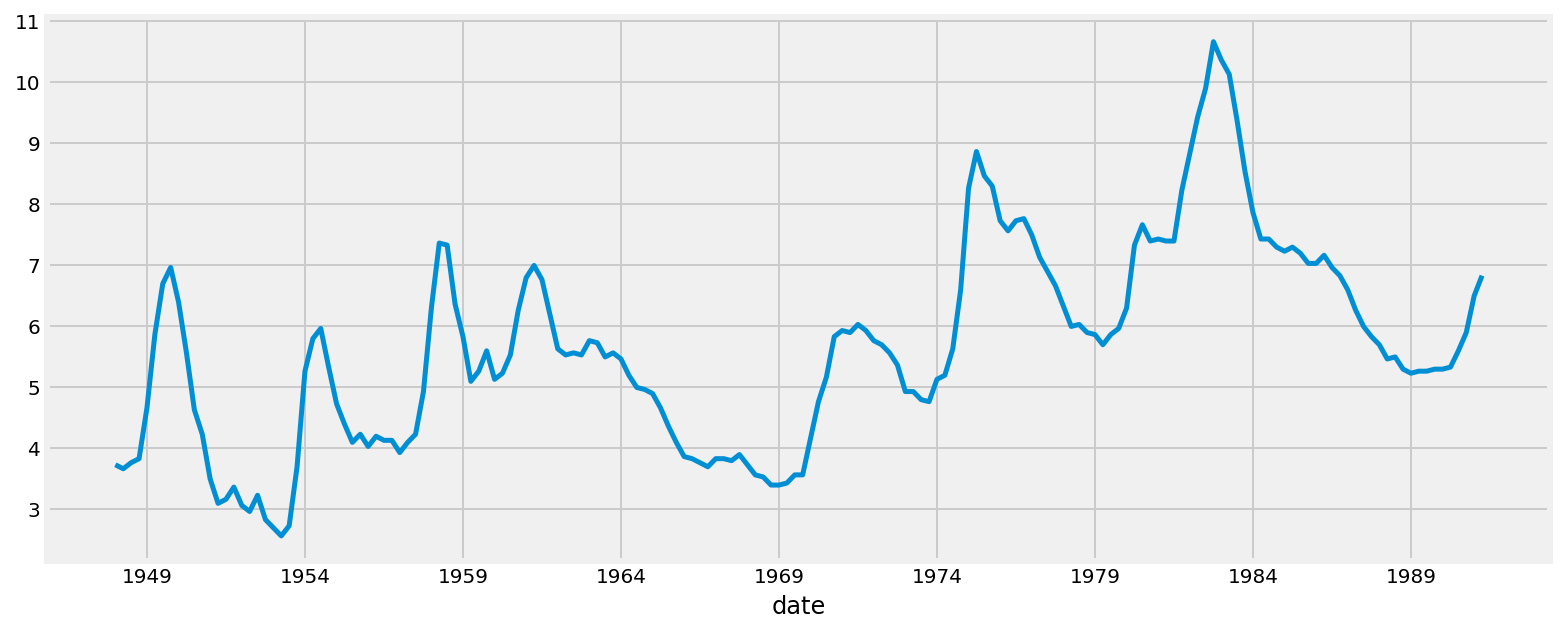

In [10]:
data['unemployment_rate'].plot(lw=2.5, figsize=(12,5));

<a id="rolling-functions"></a>
<a id="rolling-functions"></a>
## "Rolling" Functions
---

With time series, we can "roll" statistics across time. For example, the rolling mean is the mean of a moving window across time periods. Pandas offers a variety of functionalities for creating rolling statistics, which we'll only scratch the surface of here. 

The syntax for these can be a little tricky at first. We'll be using a `rolling()` function with a statistical function chained to it. Let's dive into more detail.

<a id="parameters-for-rolling-functions"></a>
<a id="parameters-for-rolling-functions"></a>
### Parameters for `rolling()` Functions

**`rolling().mean()`** (as well as **`rolling().median()`**) can take the following parameters:

- The first indicates the time series to aggregate.
- **`window`** indicates the number of days to include in the average.
- **`center`** indicates whether the window should be centered on the date or use data prior to that date.
- **`freq`** indicates which level to roll the averages up to (as used in **`resample`**): **`D`** for day, **`M`** for month, **`A`** for year, etc.

> **Note:** For more information, see Pandas' [resample documentation](http://stackoverflow.com/questions/17001389/pandas-resample-documentation).

#### Resample annually using the mean for aggregation. Plot and compare to the original time series.

In [11]:
yearly = data['unemployment_rate'].resample('A').mean()
yearly.head()

date
1948    3.75000
1949    6.05025
1950    5.20825
1951    3.28350
1952    3.02500
Freq: A-DEC, Name: unemployment_rate, dtype: float64

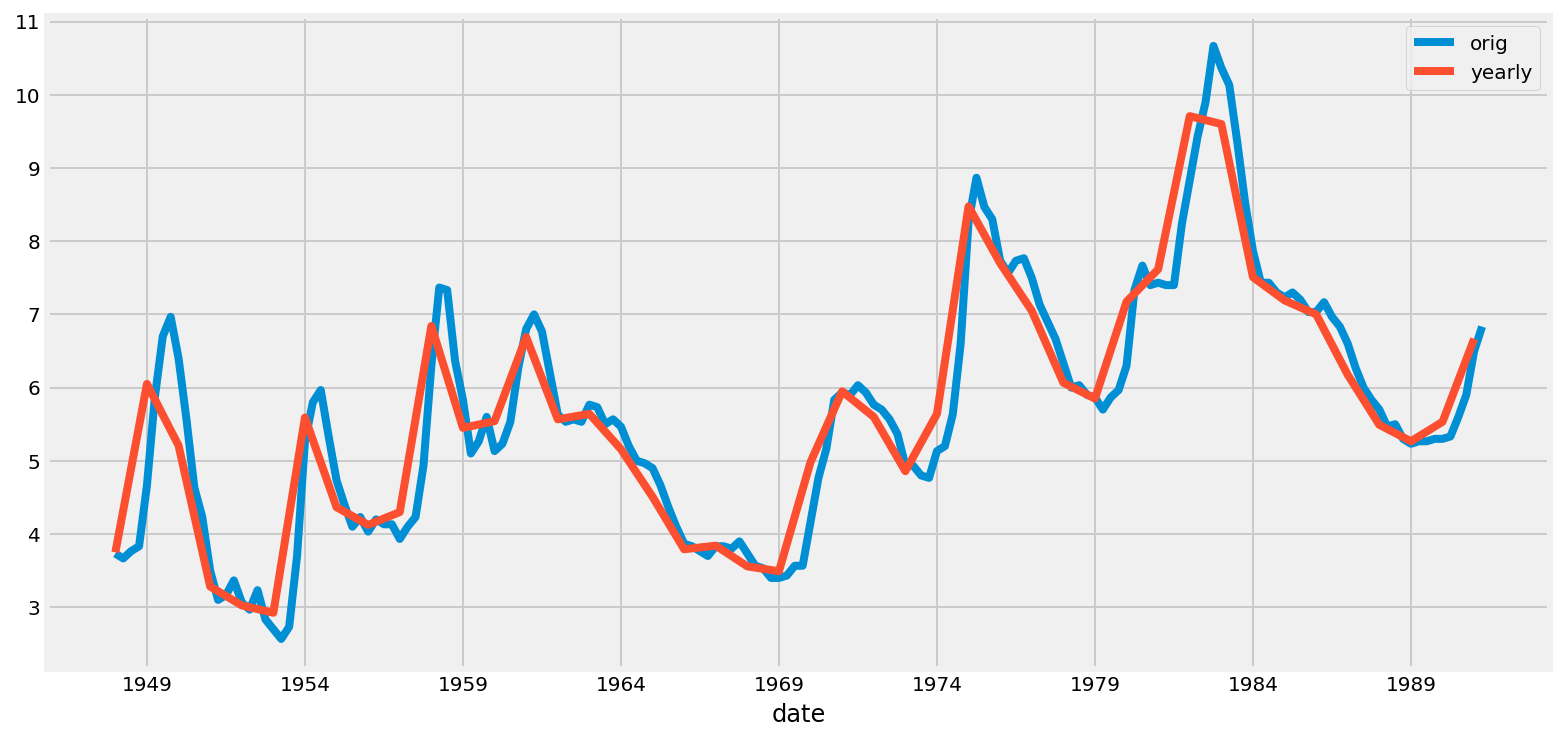

In [12]:
plt.figure(figsize=(12,6))
data.unemployment_rate.plot(label='orig',legend=True)
yearly.plot(label='yearly',legend=True);

**Extract the dates from the index as timestamps.**

> *Hint: The `.to_timestamp()` function allows you to extract the timestamps.*

In [13]:
date_ticks_orig = data.index.to_timestamp()
date_ticks_roll = yearly.index.to_timestamp()

#### Use matplotlib to plot your time series.

- Choose the time series as y-values and the timestamp-indices extracted in the last part as x-values.
- Plot both, the original timeseries and the one averaged over the windows.

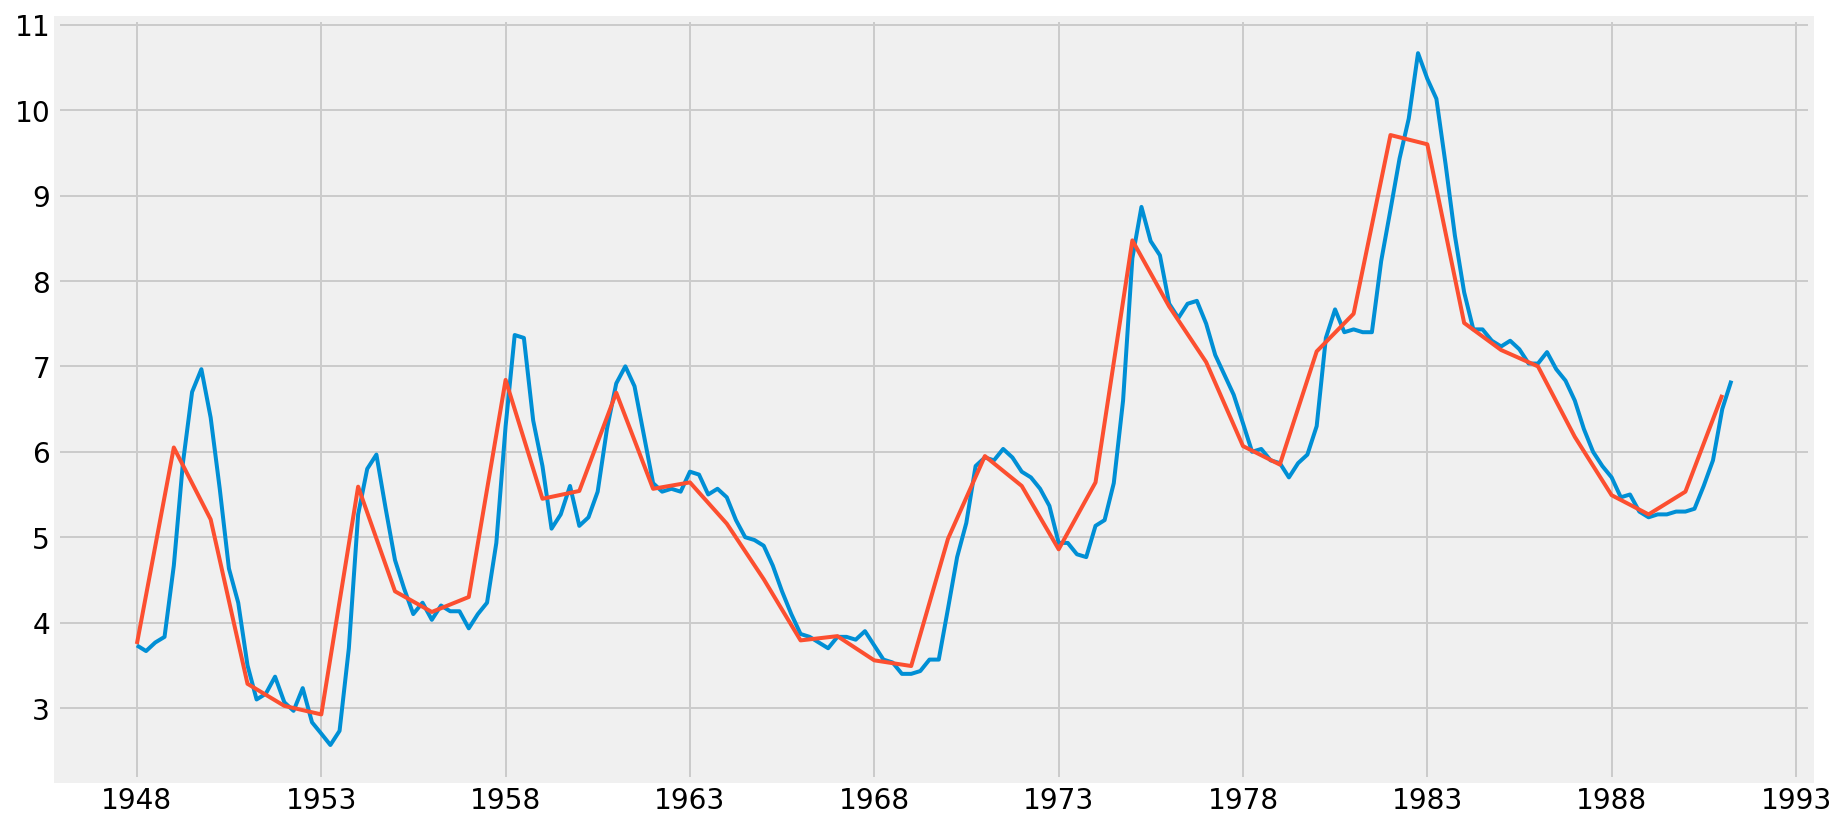

In [14]:
plt.figure(figsize=(14,7))

plt.plot(date_ticks_orig, data.unemployment_rate,lw=2)
plt.plot(date_ticks_roll, yearly.values, lw=2)

plt.tick_params(labelsize=14)

#### Resample annually and calculate the rolling mean of years with `window=3`  without centering.

In [15]:
yearly_3 = yearly.rolling(window=3, center=False).mean()
yearly_3.head()

date
1948         NaN
1949         NaN
1950    5.002833
1951    4.847333
1952    3.838917
Freq: A-DEC, Name: unemployment_rate, dtype: float64

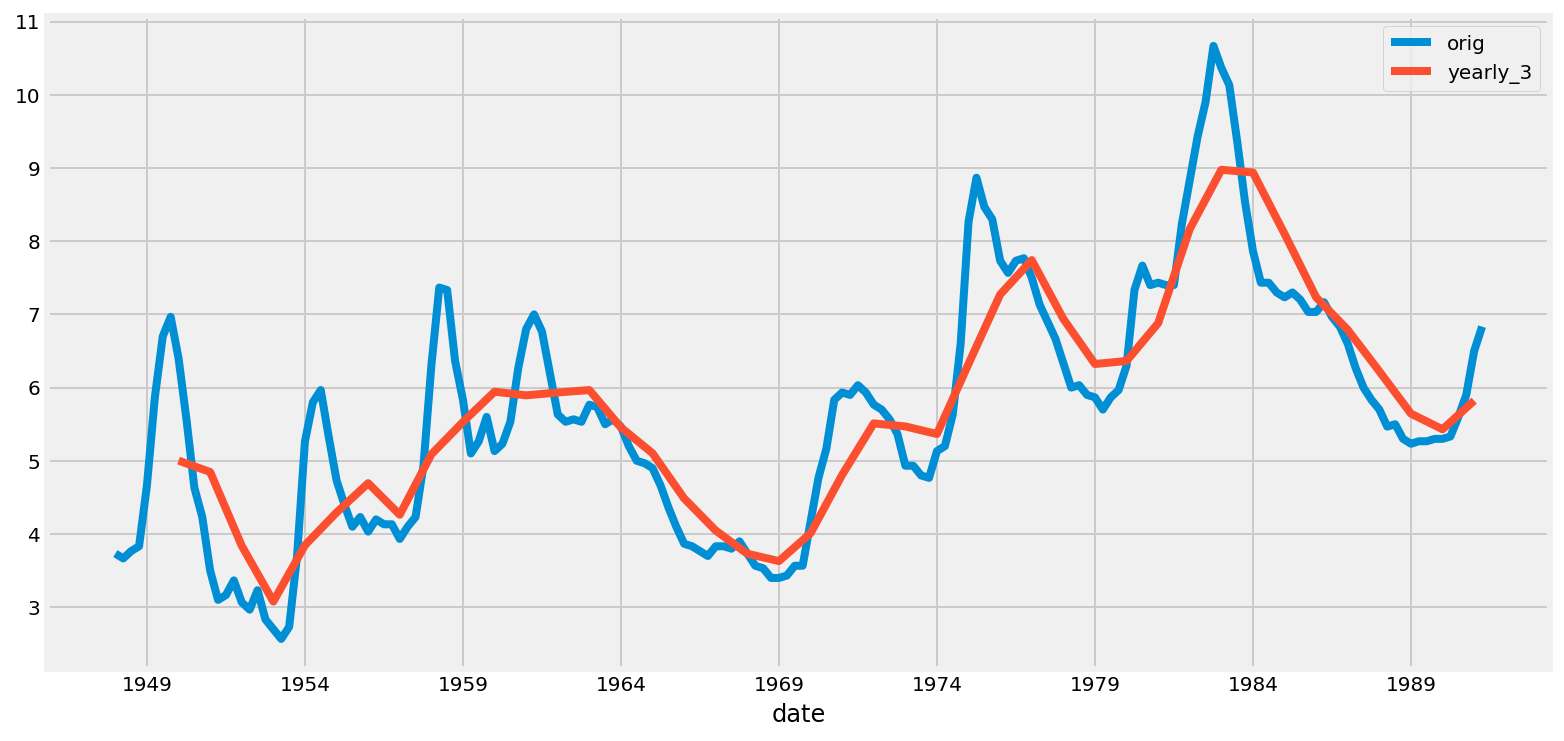

In [16]:
plt.figure(figsize=(12,6))
data.unemployment_rate.plot(label='orig',legend=True)
yearly_3.plot(label='yearly_3',legend=True);

#### Calculate the rolling median with `window=5` and `window=15`. Plot both together.

In [17]:
uroll_w5 = data.unemployment_rate.rolling(window=5).median()
uroll_w15 = data.unemployment_rate.rolling(window=15).median()

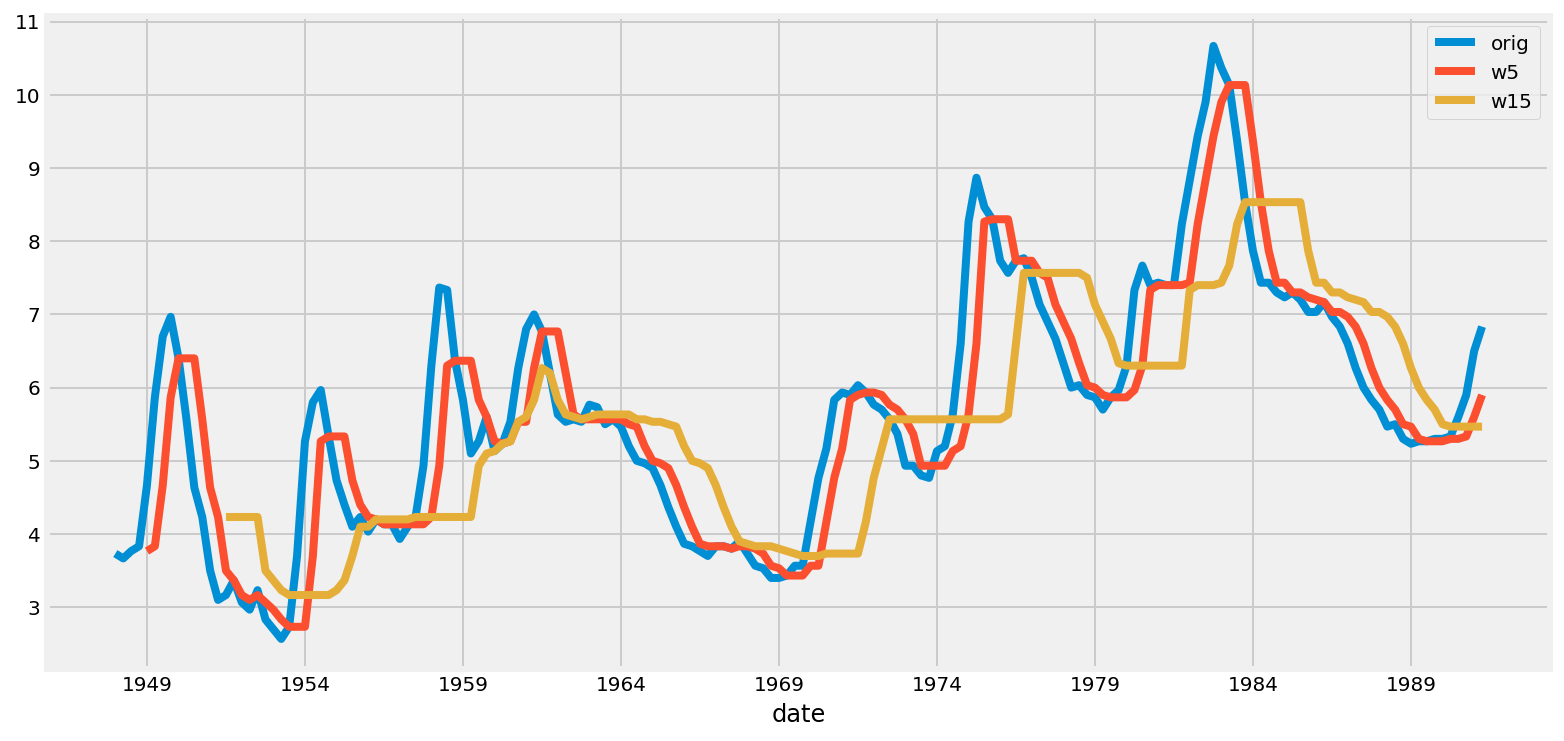

In [18]:
plt.figure(figsize=(12,6))
data.unemployment_rate.plot(label='orig',legend=True)
uroll_w5.plot(label='w5',legend=True)
uroll_w15.plot(label='w15',legend=True);

## The Expanding Mean
---

The "expanding mean" uses all data points up to the current time to calculate the mean, as opposed to a moving window.

#### Calculate and plot the expanding mean below. Resample by quarter.

Use 

`data.unemployment_rate.resample('Q').sum().expanding().mean()`.

In [19]:
expanding_mean = data.unemployment_rate.resample('Q').sum().expanding().mean()
expanding_mean.head()

date
1948Q1    3.733000
1948Q2    3.700000
1948Q3    3.722333
1948Q4    3.750000
1949Q1    3.933400
Freq: Q-DEC, Name: unemployment_rate, dtype: float64

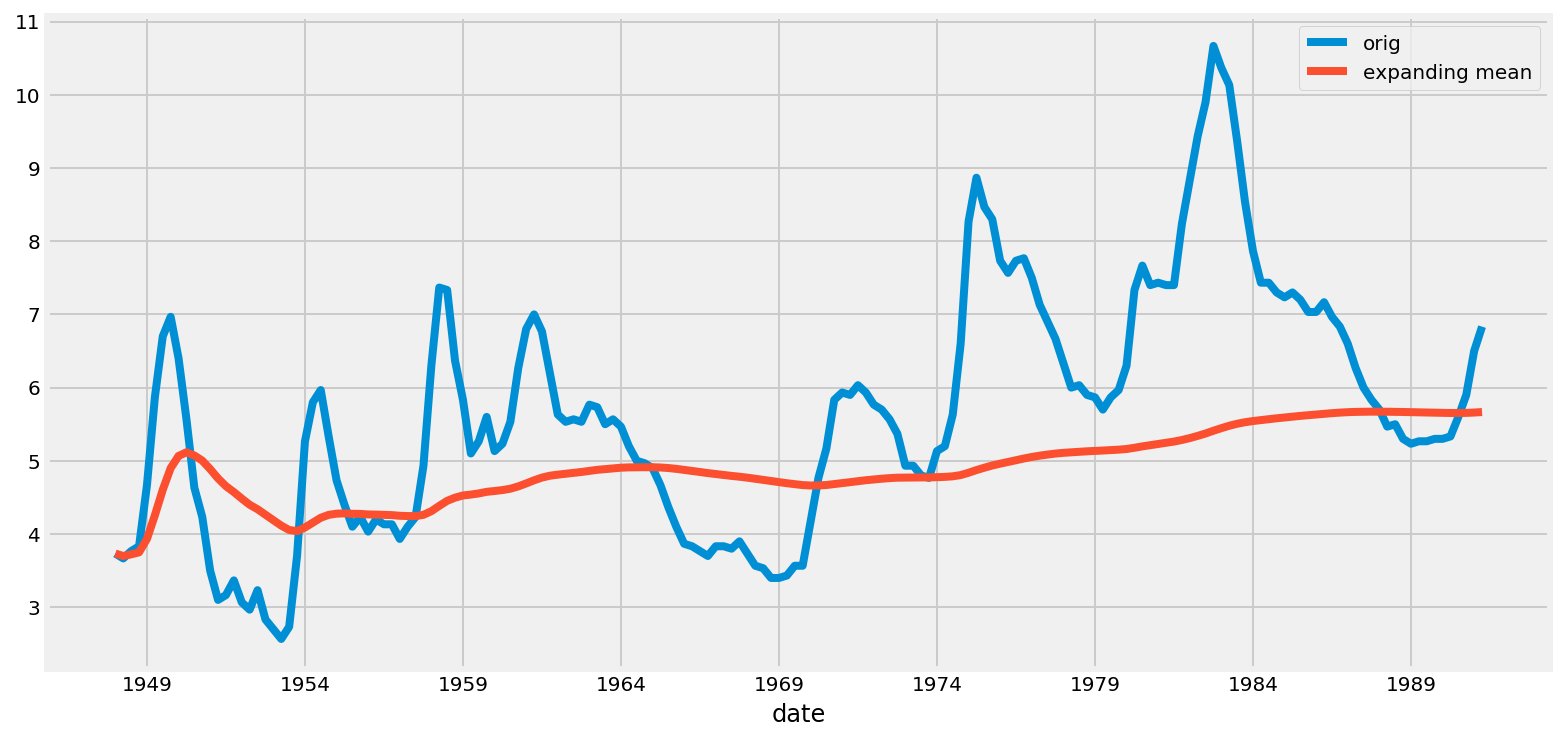

In [20]:
plt.figure(figsize=(12,6))
data.unemployment_rate.plot(label='orig',legend=True)
expanding_mean.plot(label='expanding mean',legend=True);

<a id="exponentially-weighted-windows"></a>
<a id="exponentially-weighted-windows"></a>
## Exponentially Weighted Windows
---

Exponentially weighted windows are one of the most common and effective ways of averaging out noise in time series data. The averaging is done with an "exponential decay" on the contribution of prior means, decreasing the contribution of time points that are further in the past.

The (adjusted) exponentially weighted mean for time $t$, is defined as:

$$ x_t = \frac{x_t + (1 - \alpha)x_{t-1} + (1 - \alpha)^2x_{t-2} + ... + (1 - \alpha)^{t}x_0} {1 + (1 - \alpha) + (1 - \alpha)^2 + ... + (1 - \alpha)^{t}} $$

> **Note:** Review Pandas' [documentation](http://pandas.pydata.org/pandas-docs/stable/computation.html#exponentially-weighted-windows) for more information.

#### Calculate and plot the exponentially weighted sum along with the rolling sum. What is the difference?

For example: `.resample('Q').sum().ewm(span=10).mean()`.

- Find out what `span` does.

In [21]:
exp_weighted_mean = data.unemployment_rate.resample('Q').sum().ewm(span=10).mean()

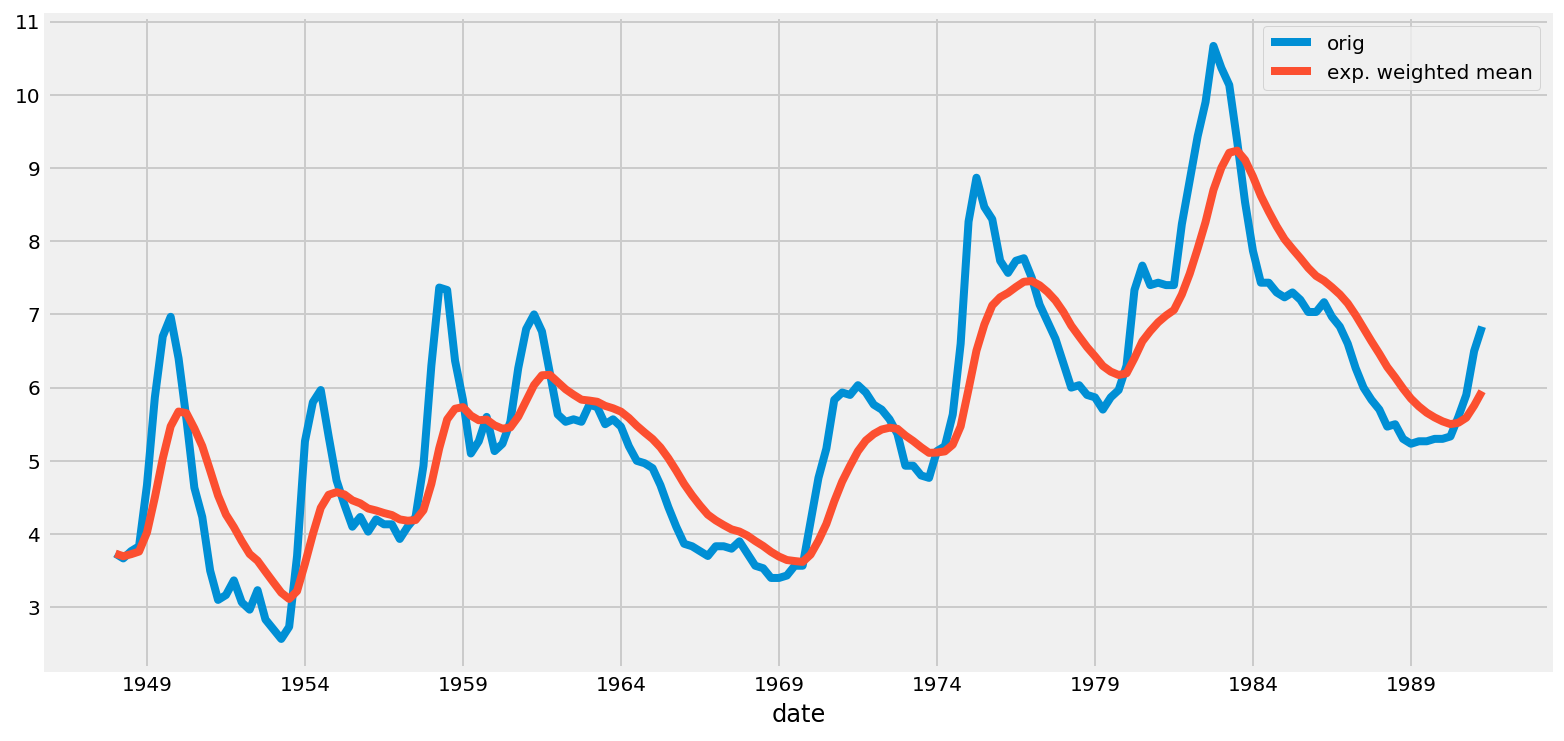

In [22]:
plt.figure(figsize=(12,6))
data.unemployment_rate.plot(label='orig',legend=True)
exp_weighted_mean.plot(label='exp. weighted mean',legend=True);